# Sample Creation Demo (Single Analysis Hour)

Starting with MYRORSS-Intermediate munged data (see `scripts/process_myrorss_to_intermediate.py`), this notebook demonstrates the creation of morphology samples at a single analysis hour for both the full zarr dataset (every storm report in database) and the reduced set of images for manual labeling (after applying a point density reduction to reduce redundancy). If your use case requires more or less images, feel free to follow create your own figures from the full zarr dataset(s)!

Analysis Hour Used: 2011-04-27 21:00Z

In [8]:
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import USSTATES, USCOUNTIES
from metpy.units import units
import pandas as pd
from pyart.graph.cm_colorblind import HomeyerRainbow
import numpy as np
from skimage.measure import regionprops
import xarray as xr
import zarr

# Local Utils
from utils.segmentation import *  # noqa: F403

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Density Reduction Parameters
density_reduction_radius = 96 * units.km

# Segmentation Parameters (without units)
conv_buffer_length = 48  # km
strat_buffer_length = 192  # km
system_min_length = 75  # km
scale_factor = 2  # km
min_cell_spacing = 20  # km
min_cell_threshold = 5  # dBZ
stratiform_threshold = 20.  # dBZ
convective_threshold = 40.  # dBZ
intense_threshold = 50.  # dBZ

conv_buffer = int(np.ceil(conv_buffer_length / (3 * scale_factor)))  # km --> pixels
strat_buffer = int(np.ceil(strat_buffer_length / (3 * scale_factor)))   # km --> pixels
min_length = int(np.ceil(system_min_length / scale_factor))  # km --> pixels
sub_conv_buffer = 1  # pixels
cell_neighboorhood_size = np.floor(min_cell_spacing / (scale_factor * 2)).astype(int) * 2 + 1
cell_h = min_cell_threshold

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Define analysis time
analysis_time = pd.Timestamp("2011-04-27 21:00")

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Load reports at analysis time, filtering out bad locations (null island)
all_reports = pd.read_csv("~/research/spc_all_reports_2000_to_2019.csv", parse_dates=['datetime'])

reports = all_reports[(all_reports['datetime'].round("H") == analysis_time) & (all_reports['lon'] < 0)].copy()

reports

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,datetime,om,yr,mo,dy,tz,st,stf,stn,...,sg,f1,f2,f3,f4,unique_id,lon,lat,fc,mt
311140,4845,2011-04-27 20:35:00,303570,2011,4,27,3,MS,28,0,...,0,17,0,0,0,spc_hail_2011_303570,-88.7500,34.0000,NaN,NaN
311141,4846,2011-04-27 20:36:00,312283,2011,4,27,3,MS,28,0,...,0,121,0,0,0,spc_hail_2011_312283,-90.2300,32.0800,NaN,NaN
311142,4847,2011-04-27 20:37:00,312099,2011,4,27,3,MS,28,0,...,0,155,0,0,0,spc_hail_2011_312099,-89.2600,33.5300,NaN,NaN
311143,4848,2011-04-27 20:38:00,316132,2011,4,27,3,AL,1,0,...,0,93,0,0,0,spc_hail_2011_316132,-87.9800,34.1400,NaN,NaN
311144,4849,2011-04-27 20:40:00,303571,2011,4,27,3,MS,28,0,...,0,57,0,0,0,spc_hail_2011_303571,-88.4700,34.2300,NaN,NaN
311145,4850,2011-04-27 20:44:00,311249,2011,4,27,3,AL,1,0,...,0,79,0,0,0,spc_hail_2011_311249,-87.4800,34.4600,NaN,NaN
311146,4851,2011-04-27 20:45:00,311250,2011,4,27,3,AL,1,0,...,0,79,0,0,0,spc_hail_2011_311250,-87.4800,34.4600,NaN,NaN
311147,4852,2011-04-27 20:50:00,300857,2011,4,27,3,VA,51,0,...,0,137,0,0,0,spc_hail_2011_300857,-77.9900,38.1500,NaN,NaN
311148,4853,2011-04-27 20:58:00,303850,2011,4,27,3,VA,51,0,...,0,89,0,0,0,spc_hail_2011_303850,-79.6700,36.7300,NaN,NaN
311149,4854,2011-04-27 21:19:00,312121,2011,4,27,3,MS,28,0,...,0,129,0,0,0,spc_hail_2011_312121,-89.7200,32.1800,NaN,NaN


In [13]:
# Load radar data for time we need data for
myrorss = xr.open_zarr("/ssd1/myrorss_intermediate/subset_2011.zarr/").sel(time=slice(analysis_time - pd.Timedelta(2, "H"), analysis_time + pd.Timedelta(2, "H"))).metpy.parse_cf()

myrorss

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:                   (time: 5, x: 2350, y: 1500)
Coordinates:
  * time                      (time) datetime64[ns] 2011-04-27T19:00:00 ... 2...
  * x                         (x) float64 -2.3e+06 -2.298e+06 ... 2.398e+06
  * y                         (y) float64 -1.5e+06 -1.498e+06 ... 1.498e+06
    metpy_crs                 object Projection: lambert_conformal_conic
Data variables:
    echo_top_height           (time, y, x) float32 dask.array<chunksize=(1, 188, 588), meta=np.ndarray>
    low_level_rotation_track  (time, y, x) float32 dask.array<chunksize=(1, 188, 588), meta=np.ndarray>
    mid_level_rotation_track  (time, y, x) float32 dask.array<chunksize=(1, 188, 588), meta=np.ndarray>
    projection                int64 ...
    reflectivity              (time, y, x) float32 dask.array<chunksize=(1, 188, 588), meta=np.ndarray>

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/jthielen/develop/MetPy/src/metpy/calc/tools.py:298: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  keep = np.ones(len(points), dtype=np.bool)


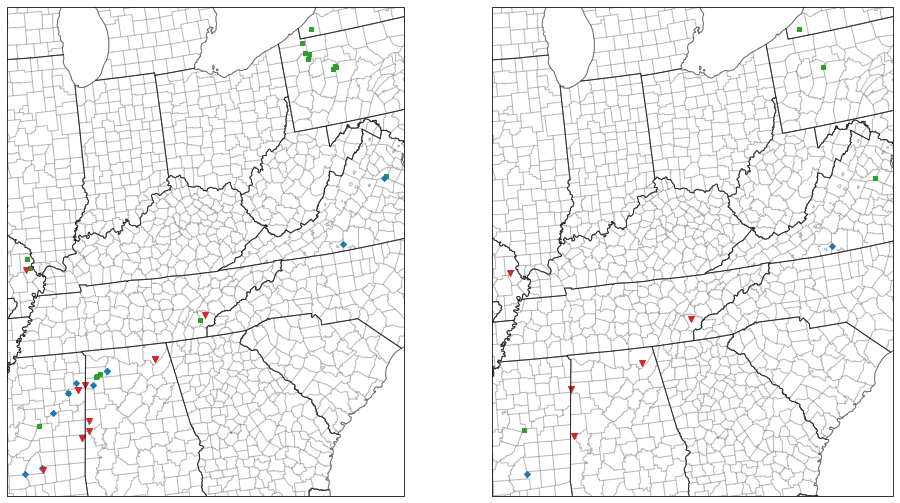

In [33]:
# Apply the point reduction (prioritized by proximity to analysis time), and demonstrate effects
reports_xy = myrorss.reflectivity.metpy.cartopy_crs.transform_points(ccrs.PlateCarree(), reports['lon'].to_numpy(), reports['lat'].to_numpy())[:, :2]
reports['x'] = reports_xy[:, 0]
reports['y'] = reports_xy[:, 1]
reduced_index = mpcalc.reduce_point_density(reports_xy * units.m, density_reduction_radius, priority=-np.abs(reports['datetime'] - analysis_time))
report_subset = reports.iloc[reduced_index]

fig, axes = plt.subplots(1, 2, figsize=(16, 9), subplot_kw={'projection': myrorss.reflectivity.metpy.cartopy_crs})

for ax, report_df in zip(axes, (reports, report_subset)):
    for report_type, size, marker, color in (
        ('wind', 18, 's', 'tab:green'),
        ('hail', 18, 'D', 'tab:blue'),
        ('torn', 36, 'v', 'tab:red')
    ):
        type_subset = report_df[report_df['unique_id'].apply(lambda s: report_type in s)]
        ax.scatter(type_subset['x'], type_subset['y'], s=size, marker=marker, c=color)
    ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=1, edgecolor=(0, 0, 0, 0.15), zorder=0)
    ax.add_feature(USSTATES.with_scale('5m'), linewidth=1, edgecolor=(0, 0, 0, 0.5), zorder=2)
    
plt.show()

In [32]:
report_df

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,datetime,om,yr,mo,dy,tz,st,stf,stn,...,f2,f3,f4,unique_id,lon,lat,fc,mt,x,y
311148,4853,2011-04-27 20:58:00,303850,2011,4,27,3,VA,51,0,...,0,0,0,spc_hail_2011_303850,-79.6700,36.7300,NaN,NaN,1.579869e+06,-43345.412382
311149,4854,2011-04-27 21:19:00,312121,2011,4,27,3,MS,28,0,...,0,0,0,spc_hail_2011_312121,-89.7200,32.1800,NaN,NaN,7.357025e+05,-673064.039913
324419,812,2011-04-27 20:49:00,300936,2011,4,27,3,TN,47,52,...,0,0,0,spc_torn_2011_300936,-84.3000,35.5400,0.0,NaN,1.191863e+06,-243680.291921
324420,813,2011-04-27 21:00:00,303562,2011,4,27,3,AL,1,99,...,59,0,0,spc_torn_2011_303562,-88.1932,34.1677,0.0,NaN,8.572224e+05,-438822.954976
324421,814,2011-04-27 21:01:00,301925,2011,4,27,3,AL,1,100,...,0,0,0,spc_torn_2011_301925,-85.9814,34.6208,0.0,NaN,1.053678e+06,-365669.033348
324423,816,2011-04-27 21:05:00,311051,2011,4,27,3,AL,1,101,...,107,0,0,spc_torn_2011_311051,-88.2403,32.9947,0.0,NaN,8.660470e+05,-569508.741040
324424,817,2011-04-27 21:10:00,309206,2011,4,27,3,MO,29,29,...,0,0,0,spc_torn_2011_309206,-89.7063,37.1800,0.0,NaN,6.898534e+05,-117570.335341
329901,4517,2011-04-27 20:50:00,295669,2011,4,27,3,PA,42,0,...,0,0,0,spc_wind_2011_295669,-78.8000,41.1500,NaN,EG,1.556717e+06,453471.839152
330484,5100,2011-04-27 21:02:00,300841,2011,4,27,3,VA,51,0,...,0,0,0,spc_wind_2011_300841,-77.9100,38.1800,NaN,EG,1.699497e+06,145965.929665
330899,5515,2011-04-27 21:20:00,304404,2011,4,27,3,NY,36,0,...,0,0,0,spc_wind_2011_304404,-79.3500,42.2000,NaN,EG,1.488623e+06,558980.709775


In [24]:
reports['lon'].to_numpy(), reports['lat'].to_numpy()

/home/jthielen/miniconda3/envs/main/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([-88.75  , -90.23  , -89.26  , -87.98  , -88.47  , -87.48  ,
        -87.48  , -77.99  , -79.67  , -89.72  , -88.1814,   0.    ,
          0.    ,   0.    , -88.445 , -88.445 , -88.4528, -88.4528,
        -84.3   , -88.1932, -85.9814, -85.9814, -88.2403, -89.7063,
        -89.6912, -78.77  , -89.64  , -89.57  , -84.48  , -78.8   ,
        -79.58  , -79.64  , -78.89  , -79.74  , -79.68  , -77.91  ,
        -88.75  , -79.35  , -89.69  , -87.85  , -87.8   , -87.73  ]),
 array([34.    , 32.08  , 33.53  , 34.14  , 34.23  , 34.46  , 34.46  ,
        38.15  , 36.73  , 32.18  , 33.2506,  0.    ,  0.    ,  0.    ,
        34.0455, 34.0455, 32.8496, 32.8496, 35.54  , 34.1677, 34.6208,
        34.6208, 32.9947, 37.18  , 32.1397, 41.13  , 37.46  , 37.23  ,
        35.43  , 41.15  , 41.59  , 41.46  , 41.09  , 41.9   , 41.63  ,
        38.18  , 34.    , 42.2   , 33.25  , 34.34  , 34.36  , 34.39  ]))

In [ ]:
# Copy and pasted version of the morphology project v1 snapshot
def plot_subset(refl_subset, snapshot_index, snapshot, cf_attrs, cmap):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': CFProjection(cf_attrs).to_cartopy()})
    fig.patch.set_facecolor('white')

    refl_subset.plot.imshow(ax=ax, norm=colors.BoundaryNorm(np.arange(0, 71, 5), 14), cmap=HomeyerRainbow, cbar_kwargs={'shrink': 0.5})
    ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=1, edgecolor=(0, 0, 0, 0.15), zorder=0)
    ax.add_feature(USSTATES.with_scale('5m'), linewidth=1, edgecolor=(0, 0, 0, 0.5), zorder=2)

    ax.set_title(f"{snapshot['unique_id']}  •  ({snapshot['lat']:.2f}, {snapshot['lon']:.2f})  •  {snapshot['datetime']:%Y-%m-%d %H:%M:00Z}\nGridRad {snapshot['analysis_time']:%Y-%m-%d %H:%M:00Z}  •  t={(snapshot_index - 2):+d} hr")

    fig_file = report_img_output_dir + 'gridrad_v1_' + snapshot['unique_id'] + '_' + chr(ord('a')+snapshot_index) + '.png'
    fig.savefig(fig_file, dpi=100, bbox_inches='tight')
    plt.close(fig)

    return fig_file